### To dos
- check skew of variables
    - apply transformations as required
- convert categoricals to dummy variables
- deal with nulls/nans (or don't)
- split off dependent/independent variables
- scale/normalise
- split into train/validate


Let's start off with some imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from collections import defaultdict
from src.analyse import test_trans
from src.analyse import analyse
from src.preprocess import clean
from src.preprocess import feat_create

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200
plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100

We'll then load up the training data

In [2]:
train_data = pd.read_csv('data/train.csv')

In [3]:
drops = ['PoolQC', 'MiscFeature', 'FireplaceQu', 'Id']
fills = {'MasVnrArea': 0.0, 'LotFrontage': 0.0}

elec_na = train_data["Electrical"].isna()
clean_data = train_data.drop(elec_na.loc[elec_na == True].index)

clean_data = clean(clean_data, drop_list=drops, fill_na=fills)

In [8]:
# skew_kurt = analyse(clean_data)
# skew_kurt.loc[(skew_kurt.Skewness >= 1) | (skew_kurt.Kurtosis >= 1)]

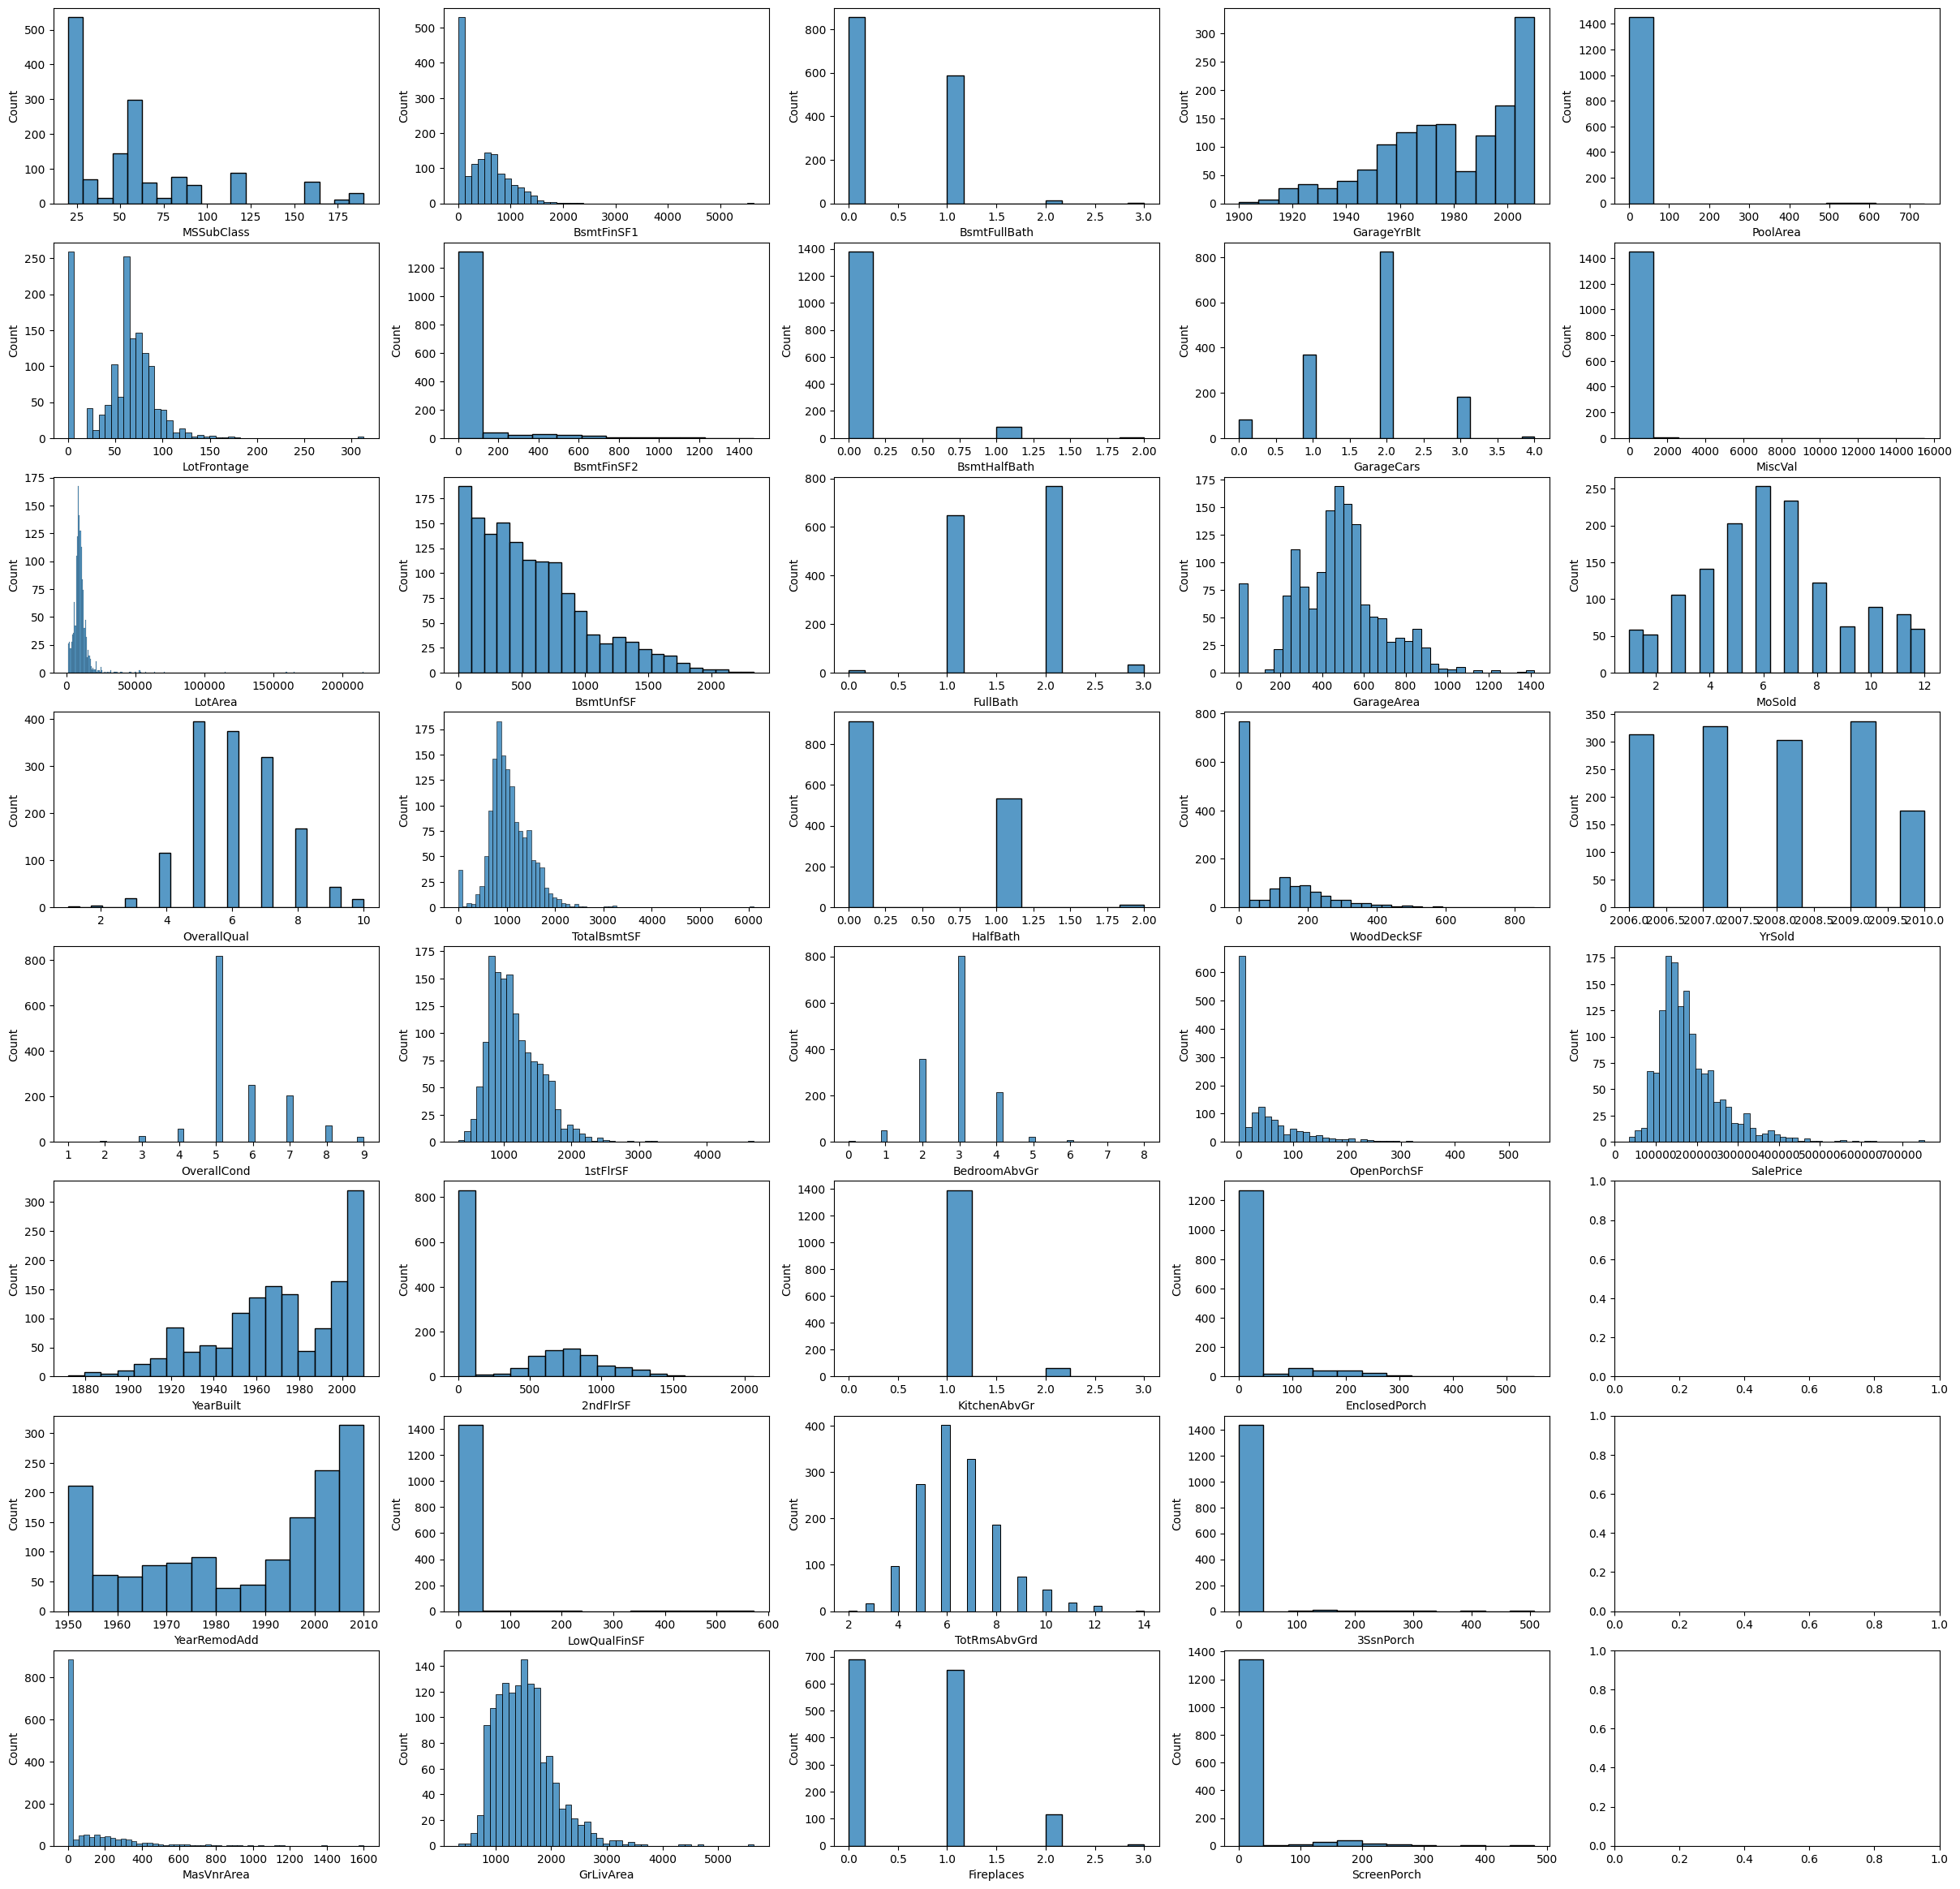

In [9]:
numerics = [col for col in clean_data.columns if clean_data.dtypes[col] != 'object']

fig, axs = plt.subplots(8,5, figsize=(30,30))
for i, column in enumerate(numerics):
    sns.histplot(data=clean_data, x = column, ax=axs[i%8, i//8])

# unique_count = defaultdict(list)
# for col in clean_data[numerics]:
#     unique_count[len(clean_data[col].unique())].append(col)

# for key in sorted(unique_count):
#     print('Number of unique values: {} | Column(s):\n{}'.format(key, unique_count[key]))

### Numerical variable adjustments
The "MSSubClass" variable presents as a numerical variable, but looking at the data description, it is in fact just a numerical encoding of a categorical variable. We will switch it back.

In [10]:
swap_subclass = {20:'1story 1946+', 
                 30:'1story 1946-', 
                 40:'1story w attic', 
                 45:'1halfstory unfinish', 
                 50:'1halfstory finish', 
                 60:'2story 1946+', 
                 70:'2story 1946-', 
                 75:'2halfstory', 
                 80:'split multi-level', 
                 85:'split foyer', 
                 90:'duplex', 
                 120:'1story PUD 1946+', 
                 150:'1halfstory PUD', 
                 160:'2story PUD 1946+', 
                 180:'PUD multilevel', 
                 190:'2 family conv'}

clean_data['MSSubClass'] = clean_data['MSSubClass'].map(swap_subclass)

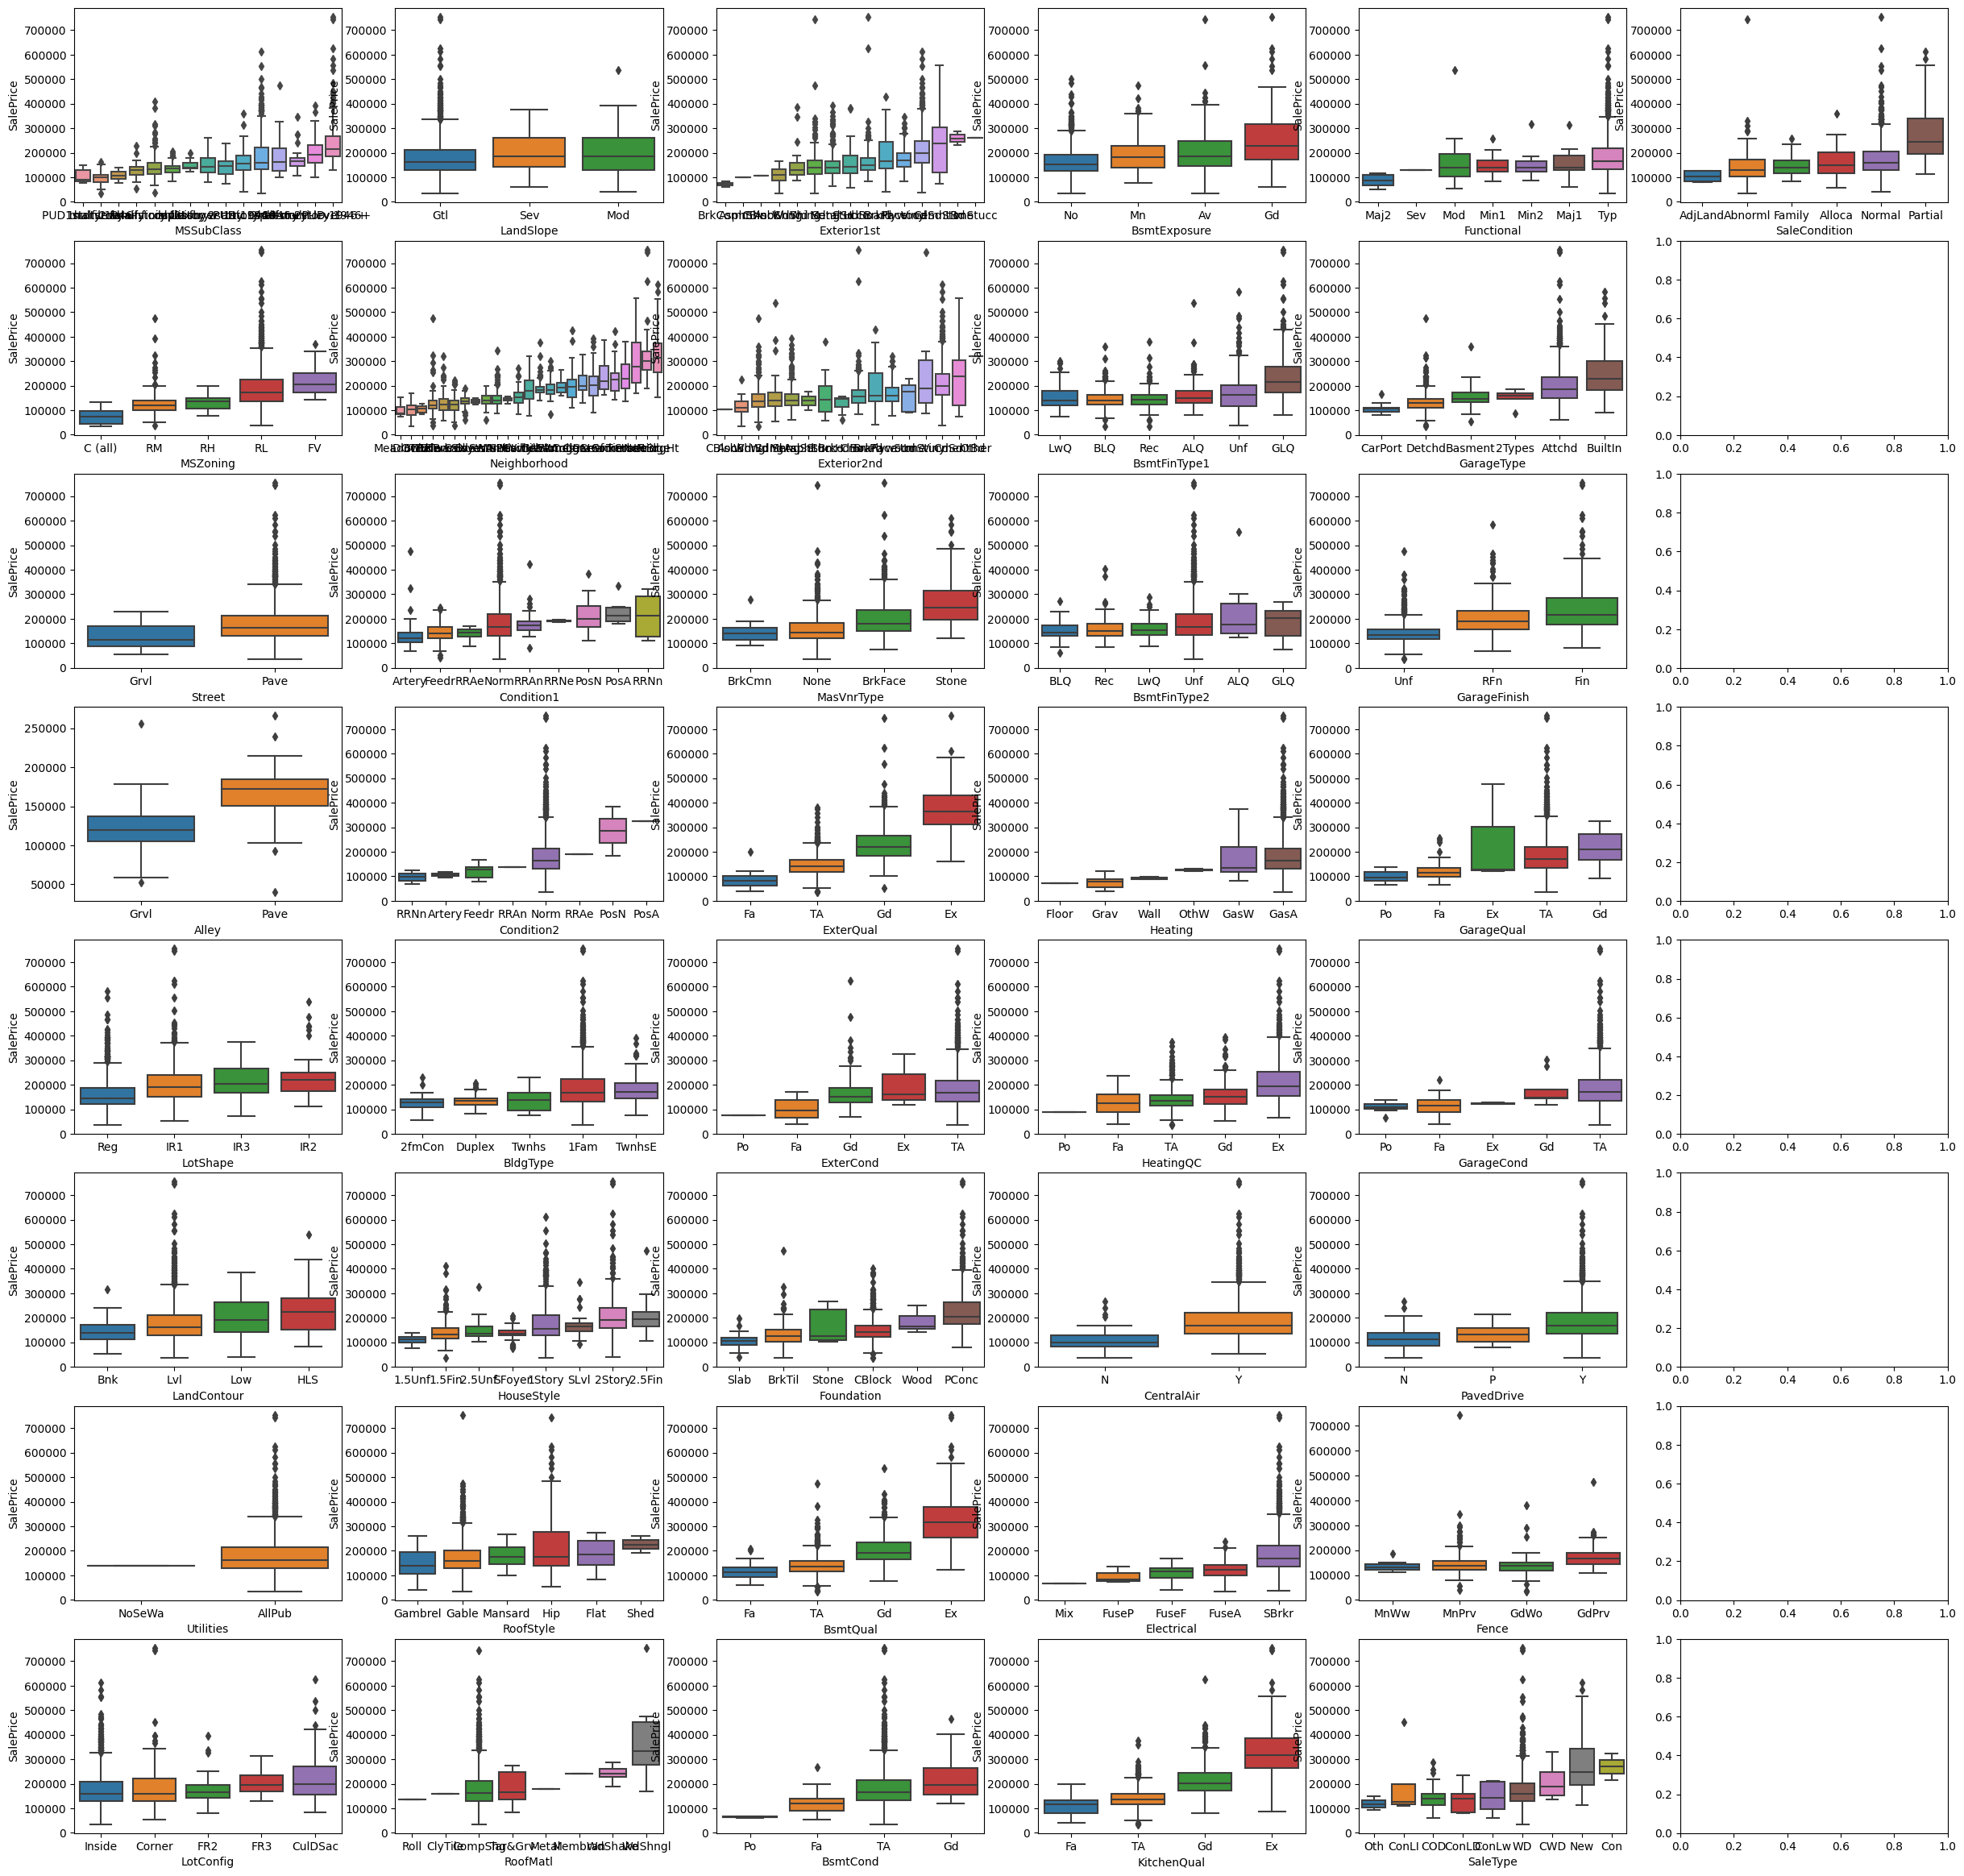

In [11]:
categories = [col for col in clean_data.columns if clean_data.dtypes[col] == 'object']

fig, axs = plt.subplots(8,6, figsize=(30,30))

for i, column in enumerate(categories):
    # The box plots will be far more interpretable if we sort them by the median SalePrice. 
    # We can achieve this using a sorted function computed on this median
    sale_sort = sorted(clean_data.groupby(column)['SalePrice'].median().items(), key = lambda x:x[1])
    order = [value[0] for value in sale_sort]
    sns.boxplot(data=clean_data, x = column, y=clean_data.SalePrice, order = order, ax=axs[i%8, i//8])

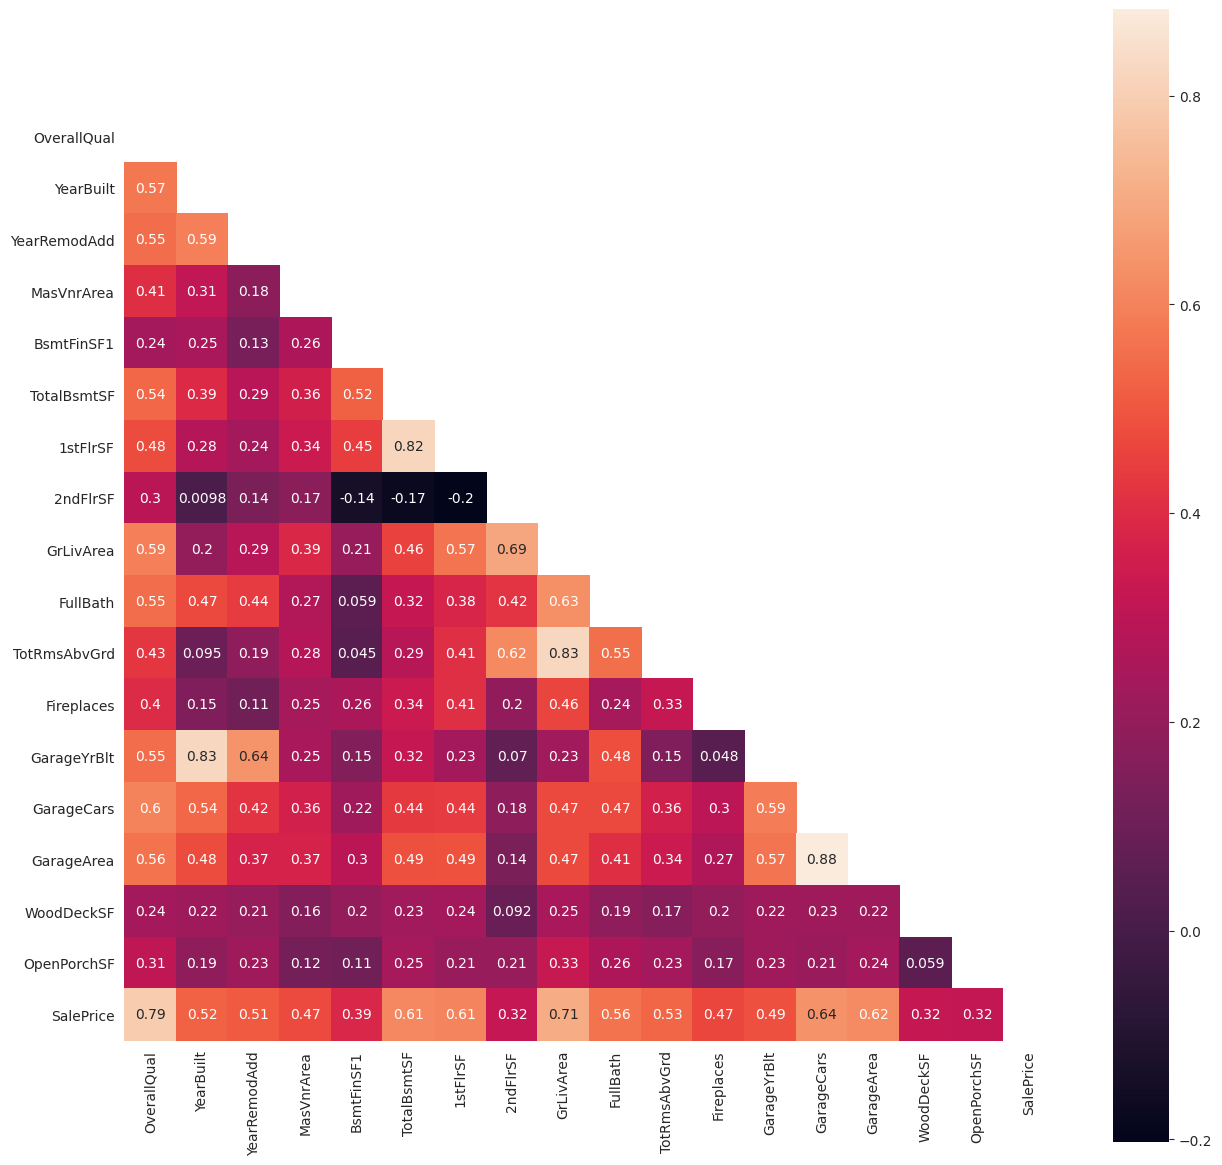

In [12]:
corr = clean_data.corr()
high_corr = list(corr[corr['SalePrice'] > 0.3]['SalePrice'].index)
corr = clean_data[high_corr].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(corr, mask=mask, annot=True, square=True)

In [13]:
# Check to make sure TotalBsmtSF holds correct number
(clean_data['BsmtUnfSF']+clean_data['BsmtFinSF1']+clean_data['BsmtFinSF2']-clean_data['TotalBsmtSF']).sum()

0

In [14]:
clean_data['Total_SF'] = clean_data['TotalBsmtSF']+clean_data['1stFlrSF']+clean_data['2ndFlrSF']
clean_data[['SalePrice', 'Total_SF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF']].corr()['SalePrice'].sort_values(ascending=False)

SalePrice       1.000000
Total_SF        0.782404
TotalBsmtSF     0.613905
1stFlrSF        0.605968
2ndFlrSF        0.319464
LowQualFinSF   -0.025620
Name: SalePrice, dtype: float64

In [15]:
clean_data['Porch_SF'] = clean_data['WoodDeckSF']+clean_data['OpenPorchSF']+clean_data['EnclosedPorch']+clean_data['3SsnPorch']+clean_data['ScreenPorch']
clean_data[['SalePrice', 'Porch_SF', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
Porch_SF         0.390973
WoodDeckSF       0.324422
OpenPorchSF      0.315831
ScreenPorch      0.111419
3SsnPorch        0.044571
EnclosedPorch   -0.128627
Name: SalePrice, dtype: float64

In [16]:
# Convert quality/condition variables (encoded as categoricals) 
# into ordinal type numerics
qual_mapper = {'NA': 0 , 'Po': 1, 'Fa': 2, 'TA':3, 'Gd':4, 'Ex': 5}
qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']

if 'object' in list(clean_data[qual_vars].dtypes):
    for variable in qual_vars:   
        clean_data[variable] = clean_data[variable].replace(qual_mapper)

In [17]:
clean_data['Total_Bath'] = clean_data['BsmtFullBath']+clean_data['BsmtHalfBath']*0.5+clean_data['FullBath']+clean_data['HalfBath']*0.5
clean_data[['SalePrice', 'Total_Bath', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']].corr()['SalePrice'].sort_values(ascending=False)

SalePrice       1.000000
Total_Bath      0.631809
FullBath        0.560881
HalfBath        0.284400
BsmtFullBath    0.227082
BsmtHalfBath   -0.016873
Name: SalePrice, dtype: float64

In [18]:
# Clean up the original features we used to produce our useful features
cleanup = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch','TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF']
tidy = clean(clean_data, drop_list=cleanup)
# types = tidy.dtypes
# categories = list(types[types == object].index)
# tidy[categories] = tidy[categories].astype('category')

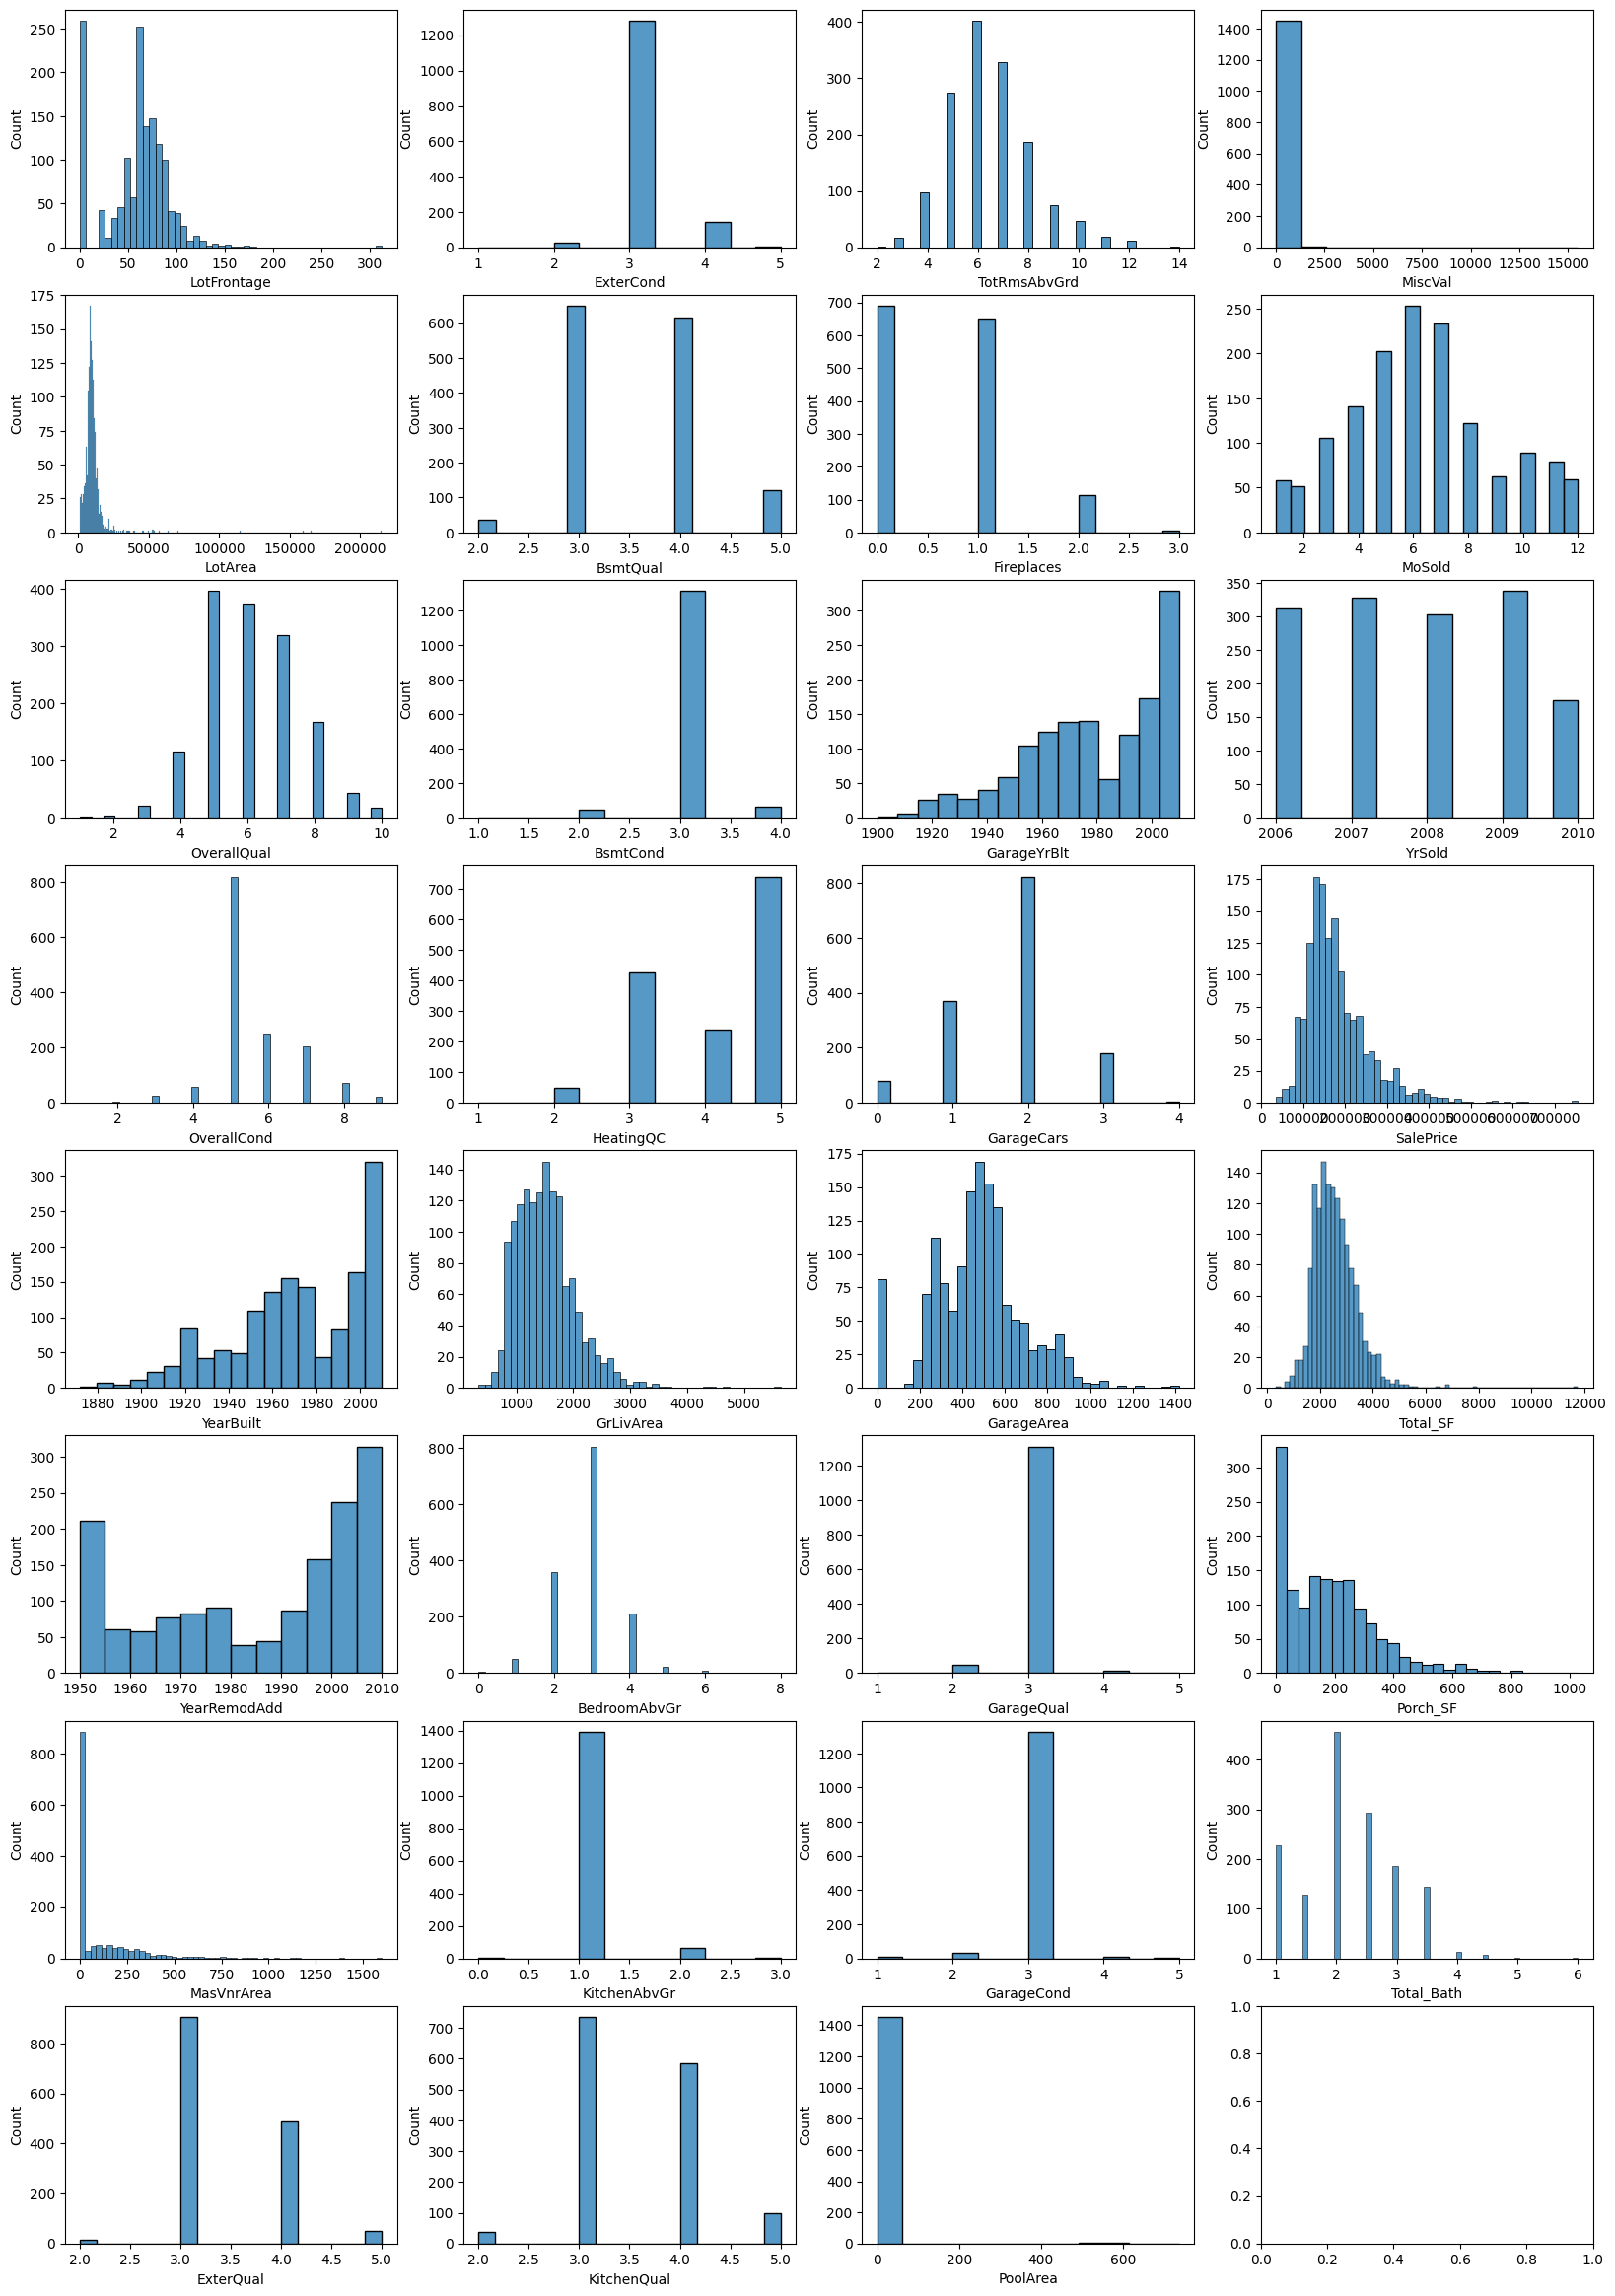

In [19]:
numerics = [col for col in tidy.columns if tidy.dtypes[col] != 'object']

fig, axs = plt.subplots(8,4, figsize=(20,30))
for i, column in enumerate(numerics):
    sns.histplot(data=tidy, x = column, ax=axs[i%8, i//8])

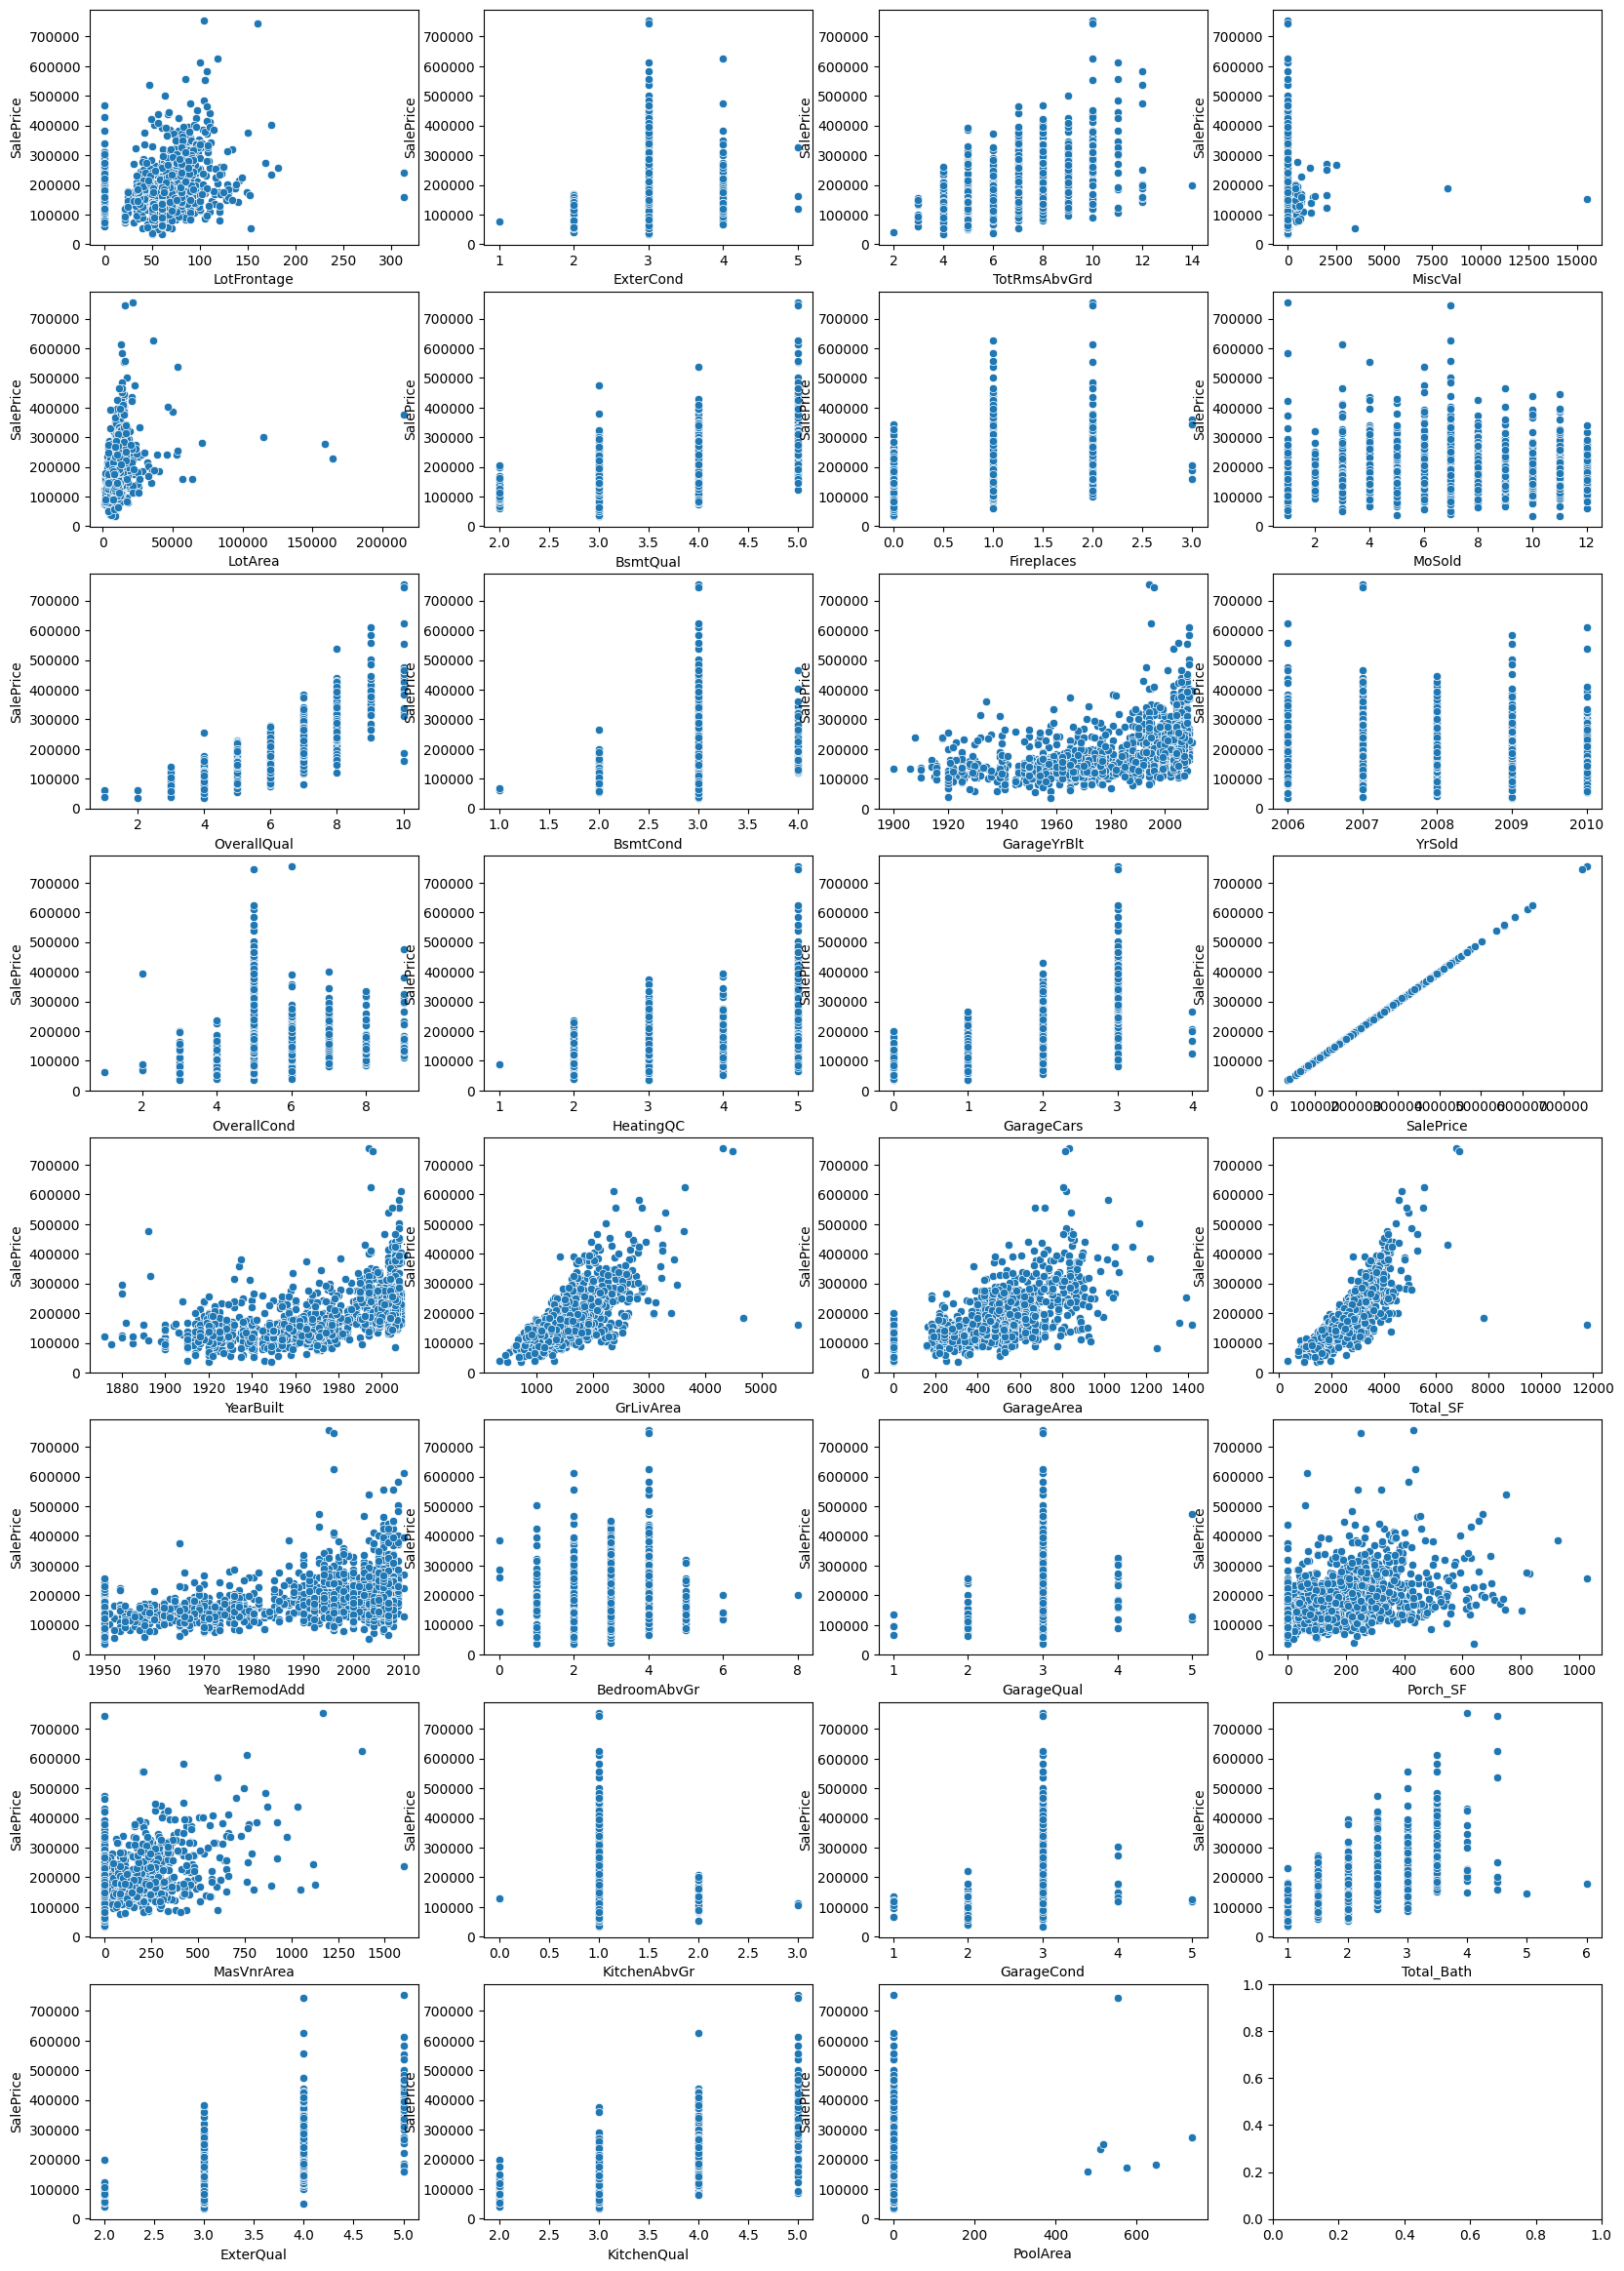

In [20]:
fig, axs = plt.subplots(8,4, figsize=(20,30))
for i, column in enumerate(numerics):
    sns.scatterplot(data=tidy, x = column, y='SalePrice', ax=axs[i%8, i//8])

In [21]:
tidy[(tidy['SalePrice']<250000) & (tidy['Total_SF']>6000)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_SF,Porch_SF,Total_Bath
523,2story 1946+,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,5,3,PConc,5.0,3.0,Gd,GLQ,Unf,GasA,5,Y,SBrkr,4676,3,1,5,11,Typ,1,BuiltIn,2007.0,Fin,3,884,3.0,3.0,Y,0,NaN,0,10,2007,New,Partial,184750,7814,614,4.5
1298,2story 1946+,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,5,3,PConc,5.0,3.0,Gd,GLQ,Unf,GasA,5,Y,SBrkr,5642,3,1,5,12,Typ,3,Attchd,2008.0,Fin,2,1418,3.0,3.0,Y,480,NaN,0,1,2008,New,Partial,160000,11752,506,4.5


In [22]:
high_corr = tidy.drop([523,1298]).corr()['SalePrice'].sort_values(ascending=False)
high_corr[high_corr > 0.5]

SalePrice       1.000000
Total_SF        0.833058
OverallQual     0.795863
GrLivArea       0.734962
ExterQual       0.686795
KitchenQual     0.662454
BsmtQual        0.646594
GarageCars      0.641111
Total_Bath      0.635977
GarageArea      0.629209
TotRmsAbvGrd    0.537826
YearBuilt       0.523986
YearRemodAdd    0.508047
Name: SalePrice, dtype: float64

In [23]:
clean_data[['FullBath', 'BsmtFullBath']].sum(axis=1)

0       3
1       2
2       3
3       2
4       3
       ..
1455    2
1456    3
1457    2
1458    2
1459    2
Length: 1459, dtype: int64

In [4]:
bath_dict = {"Test_Total_Bath": {1:['BsmtFullBath','FullBath'], 0.5: ['BsmtHalfBath', 'HalfBath']}}
test_create = feat_create(clean_data, bath_dict)
clean_data['Total_Bath'] = clean_data['BsmtFullBath']+clean_data['BsmtHalfBath']*0.5+clean_data['FullBath']+clean_data['HalfBath']*0.5
print(clean_data['Total_Bath'])
print(test_create['Test_Total_Bath'])

0       3.5
1       2.5
2       3.5
3       2.0
4       3.5
       ... 
1455    2.5
1456    3.0
1457    2.0
1458    2.0
1459    2.5
Name: Total_Bath, Length: 1459, dtype: float64
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1455   NaN
1456   NaN
1457   NaN
1458   NaN
1459   NaN
Name: Test_Total_Bath, Length: 1459, dtype: float64
